**Фомин Артем Владимирович**

# Практический кейс

## «Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения»

В качестве исходных данных были взяты результаты экспериментальных исследований, проводимых в целях улучшения технологического процесса электронно-лучевой сварки изделия, сборка которого состоит из элементов, состоящих из разнородного материала. Установка электронно-лучевой сварки, на которой проводились исследования, предназначена для сварки электронным лучом в глубоком вакууме деталей сборочных единиц из нержавеющих сталей, титановых, алюминиевых и специальных сплавов. Существующая установка электронно-лучевой сварки обеспечивает повторяемость режимов в рамках возможностей реализованной системы управления.

Работы по сварке выполнялись на образцах-имитаторах, соответствующих технологическому изделию. Для уменьшения вложения энергии при сварке:
1. Снижалась величина сварочного тока (IW);
2. Увеличивался ток фокусировки электронного пучка (IF);
3. Увеличивалась скорость сварки (VW);
4. Менялось расстояние от поверхности образцов до электронно-оптической системы (FP).

По совокупности параметров технологических режимов обеспечивались минимально возможные размеры сварных швов: глубина шва (Depth) и ширина шва (Width).

В процессе выполнения работ была произведена электронно-лучевая сварка 18-ти единиц образцов. Результаты металлографического контроля по размерам сварного шва для каждого образца проводились в 4-х поперечных сечениях сварного шва. Ускоряющее напряжение было постоянным в диапазоне 19,8 – 20 кВ.

Набор полученных данных собраны в составе режимов сварки, размеров сварочных швов в поперечных сечениях всех образцов. Статистические показатели набора обучающих данных указаны в табл. 1.

**Таблица 1. Статистические показатели набора обучающих данных**

| Показатель | IW   | IF   | VW   | FP   | Depth | Width |
|------------|------|------|------|------|-------|-------|
| Количество | 72   | 72   | 72   | 72   | 72    | 72    |
| Среднее выборочное | 45,666 | 141,333 | 8,639 | 78,333 | 1,196 | 1,970 |
| Среднее квадратичное отклонение | 1,678 | 5,146 | 2,061 | 21,494 | 0,225 | 0,279 |
| Минимум | 43   | 131  | 4,5  | 50   | 0,80  | 1,68  |
| 25%   | 44   | 139  | 8    | 60   | 1,08  | 1,76  |
| 50%   | 45   | 141  | 9    | 80   | 1,20  | 1,84  |
| 75%   | 47   | 146  | 10   | 80   | 1,29  | 2,05  |
| Максимум  | 49   | 150  | 12   | 125  | 1,76  | 2,60  |

**Задача:**
Решить задачу регрессии (одним или несколькими методами) для предсказания глубины и ширины сварного соединения, выполнив необходимые этапы (разведочный анализ, предобработка).

## Решение задачи

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn import tree
import tensorflow as tf

**Функция для визуализации качества моделей**

In [2]:
def show_model_quality_visualization(model, X_test, Y_test):
    """
    Функция для визуализации качества моделей
    """
    Y_pred = model.predict(X_test)

    # Создание subplot-ов
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    
    # Первый график
    axes[0].plot(Y_test.iloc[:, 0].values, label='Тестовые данные')
    axes[0].plot(Y_pred[:, 0], label='Предсказания модели')
    axes[0].set_xlabel('Номера наборов исходных данных')
    axes[0].set_ylabel('Глубина шва (Depth)')
    axes[0].legend()
    
    # Второй график
    axes[1].plot(Y_test.iloc[:, 1].values, label='Тестовые данные')
    axes[1].plot(Y_pred[:, 1], label='Предсказания модели')
    axes[1].set_xlabel('Номера наборов исходных данных')
    axes[1].set_ylabel('Ширина шва (Width)')
    axes[1].legend()
    
    # Показать значения на графиках
    for i in range(len(Y_test)):
        axes[0].text(i, Y_test.iloc[i, 0], round(Y_test.iloc[i, 0], 2))
        axes[0].text(i, Y_pred[i, 0], round(Y_pred[i, 0], 2))
        
        axes[1].text(i, Y_test.iloc[i, 1], round(Y_test.iloc[i, 1], 2))
        axes[1].text(i, Y_pred[i, 1], round(Y_pred[i, 1], 2))
        
    # Показать графики
    plt.tight_layout()
    plt.show()
    
    mae = mean_absolute_error(Y_test, model.predict(X_test), multioutput='raw_values')
    
    print(f'Cредняя абсолютная ошибка при предсказании глубины шва (Depth):\t~ {round(mae[0] * 100, 1)} %')
    print(f'Cредняя абсолютная ошибка при предсказании ширины шва (Width):\t~ {round(mae[1] * 100, 1)} %')

### Загрузка датасета

In [3]:
df = pd.read_csv("data/ebw_data.csv")

In [4]:
df.sample(5)

,IW,IF,VW,FP,Depth,Width
42,47,140,10.0,80,1.12,1.80
49,44,146,9.0,60,1.32,1.84
44,46,146,10.0,60,1.28,1.80
39,49,132,8.0,125,0.80,2.28
2,47,139,4.5,80,1.68,2.60


**Переименование столбцов для удобства анализа**

In [5]:
# df_renamed = df.copy()
# df_renamed.rename(columns={'IW': 'Cварочный ток (IW)',
#                            'IF': 'Ток фокусировки электронного пучка (IF)',
#                            'VW': 'Скорость сварки (VW)',
#                            'FP': 'Расстояние от поверхности образцов до электронно-оптической системы (FP)',
#                            'Depth': 'Глубина шва (Depth)',
#                            'Width': 'Ширина шва (Width)',
#                           },
#                   inplace=True)

### Изучение структуры данных

In [6]:
df.describe() # Таблица, приведденная в условиях задачи

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


**Интерпретация**


- `count`: количество значений в каждом столбце. В данном случае, для каждого признака доступно 72 значений.
- `mean`: среднее значение этих значений. Например, среднее значение для признака IW равно 45.666667.
- `std`: стандартное отклонение значений. Например, для признака IF стандартное отклонение равно 5.145763.
- `min`: минимальное значение в каждом столбце. Например, минимальное значение для признака VW равно 4.5.
- `25%`, `50%`, `75%`: значения соответствующих квантилей. Например, медианное значение (50-й квантиль) для признака Depth равно 1.84.
- `max`: максимальное значение в каждом столбце. Например, максимальное значение для признака FP равноов анализа.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


**Интерпретация:**
- DataFrame имеет 72 строки (диапазон индекса от 0 до 71).
- DataFrame имеет 6 столбцов с данными.
- Каждый столбец имеет следующие атрибуты:
  - Column: имя столбца
  - Non-Null Count: количество непустых значений в столбце
  - Dtype: тип данных в столбце
- Все столбцы содержат ненулевые значения, что означает отсутствие пропущенных данных.
- Три столбца имеют тип float64:
    - скорость сварки (VW)
    - глубина шва (Depth)
    - ширина шва (Width)
- Три столбца имеют тип int64:
    - сварочный ток (IW)
    - ток фокусировки электронного пучка (IF)
    - расстояние от поверхности образцов до электронно-оптической системы (FP)
- Память, занимаемая DataFrame составляет 3.5 KB.
  
**Все данные числовые и не требуют дополнительной типизации**.

### Изучение связей между переменными

In [8]:
df.corr()

,IW,IF,VW,FP,Depth,Width
IW,1.000000,-0.861073,-0.043430,0.835530,-0.289568,0.434869
IF,-0.861073,1.000000,0.115093,-0.980562,0.376084,-0.510167
VW,-0.043430,0.115093,1.000000,-0.001060,-0.671437,-0.874257
FP,0.835530,-0.980562,-0.001060,1.000000,-0.510748,0.412962
Depth,-0.289568,0.376084,-0.671437,-0.510748,1.000000,0.425391
Width,0.434869,-0.510167,-0.874257,0.412962,0.425391,1.000000


In [9]:
df.shape

(72, 6)

**Ящиковая диаграмма**

<Axes: >

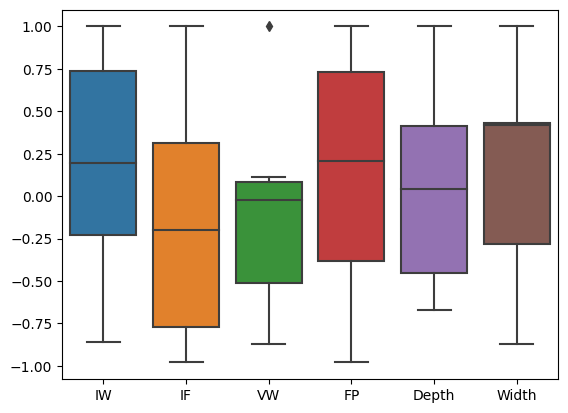

In [10]:
sns.boxplot(df.corr())

D:\dev\projects\data_scientist_bmstu\env\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


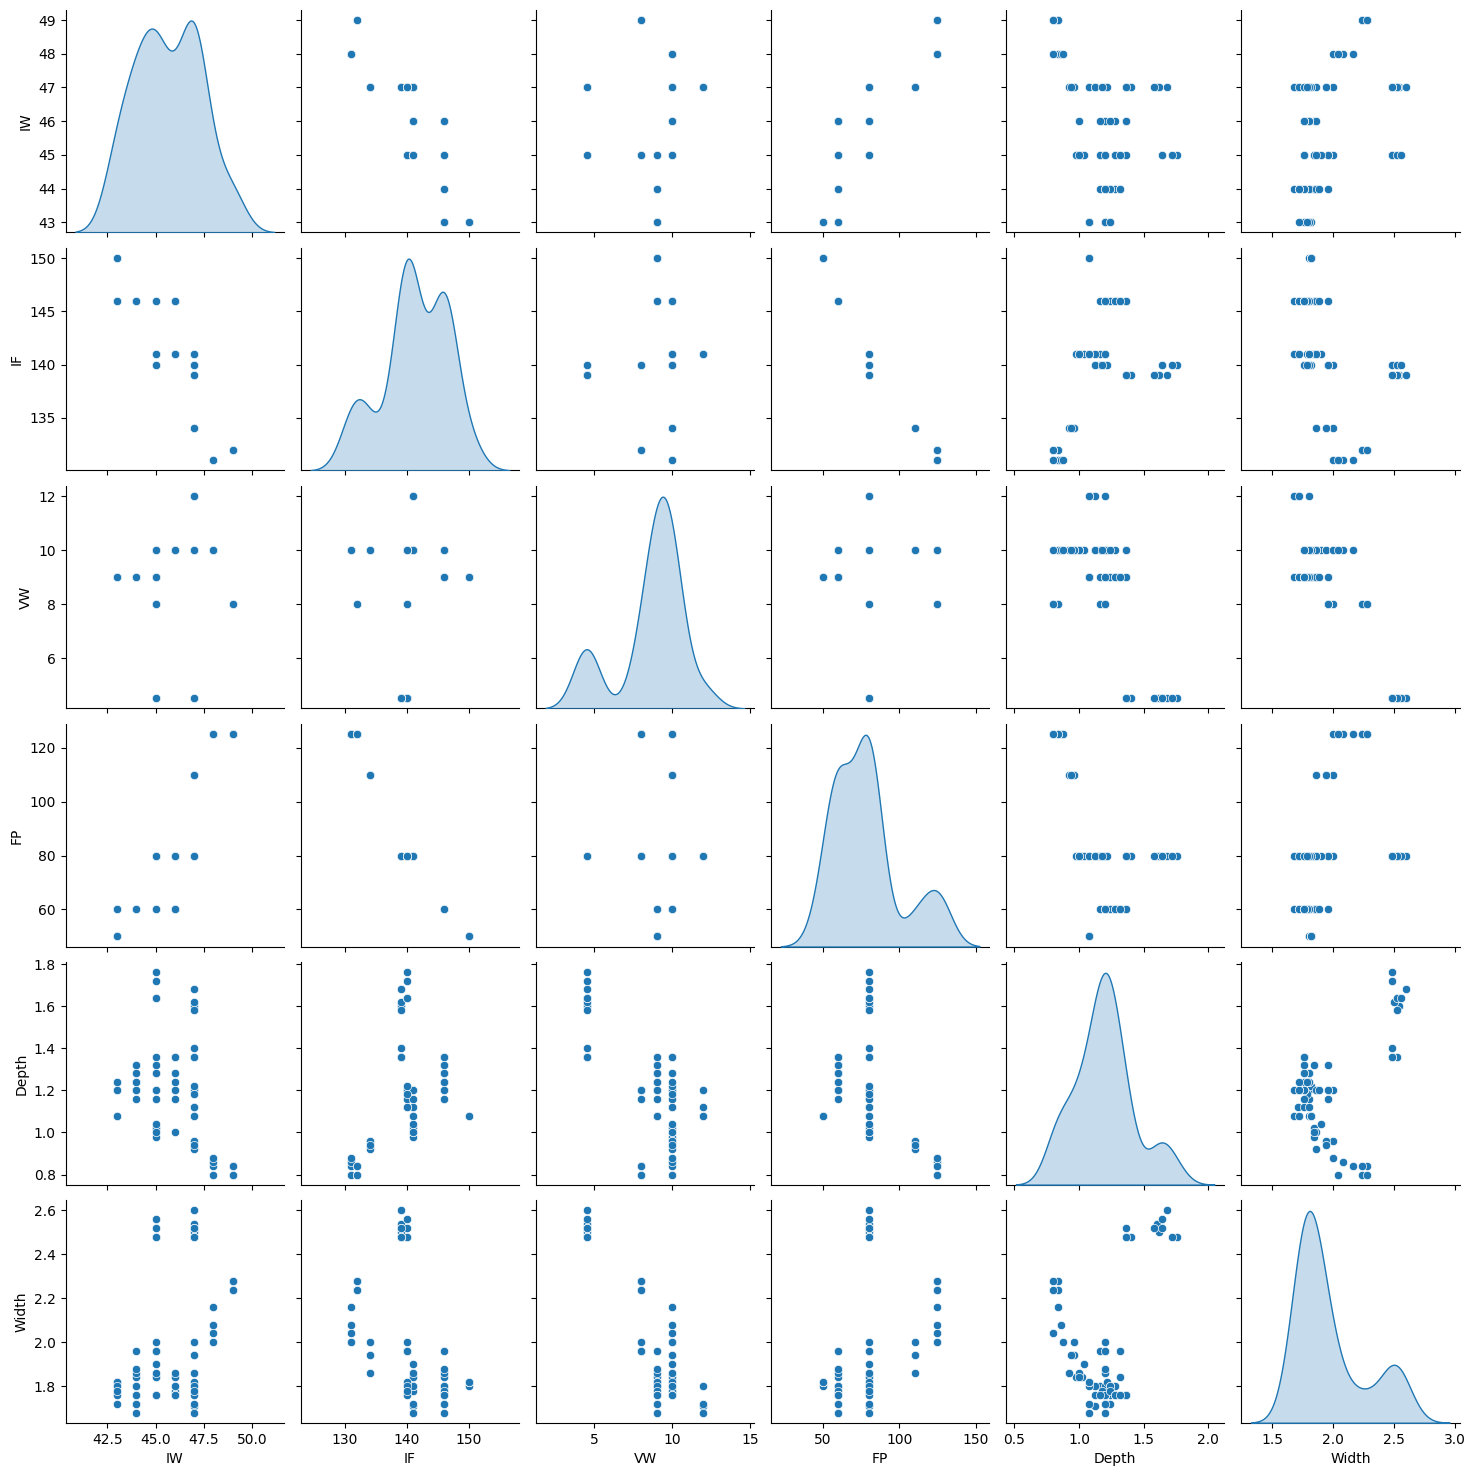

In [11]:
sns.pairplot(df, diag_kind='kde')

<Axes: >

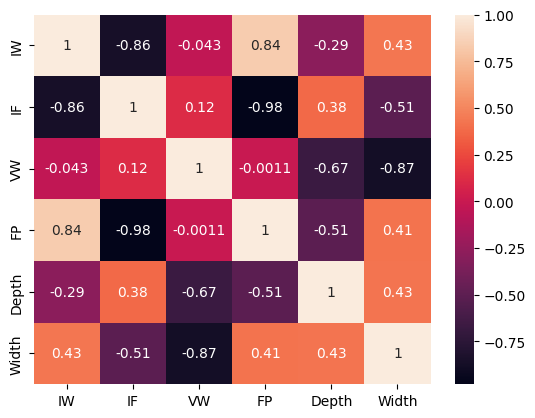

In [12]:
sns.heatmap(df.corr(), annot=True)

**Тепловая карта**

**Интерпретация**

**Целевые переменные:**

- `Глубина шва (Depth)` имеет умеренную отрицательную корреляцию со `Скоростью сварки (VW)` и `Расстоянием от поверхности образцов до электронно-оптической системы (FP)`, а также немного положительно коррелирует с `Током фокусировки электронного пучка (IF)` и немного отрицательно коррелирует со `Сварочным током (IW)`.
- `Ширина шва (Width)` сильно отрицательно коррелирует со `Скоростью сварки (VW)`, имеет отрицательную корреляцию с `Током фокусировки электронного пучка (IF)`, а также умеренно коррелирует со `Сварочным током (IW)` и `Расстоянием от поверхности образцов до электронно-оптической системы (FP)`.

**Исходные переменные**
1. `Скорость сварки (VW)` является независящей от других исходных переменных, поэтому данная переменная должна участвовать в модели.
2. `Расстояние от поверхности образцов до электронно-оптической системы (FP)` также не зависит от других исходных переменных и будет оставлена при составлении модели.
3. `Сварочный ток (IW)` сильно положительно коррелирует с `Расстоянием от поверхности образцов до электронно-оптической системы (FP)`, но является обязательным параметром для обеспечения самого процесса сварки, поэтому должен остаться в модели.
4. `Ток фокусировки электронного пучка (IF)` сильно отрицательно коррелирует со `Сварочным током (IW)` и `Расстоянием от поверхности образцов до электронно-оптической системы (FP)`, поэтому данную переменную целесообразно удалить из модели.

### Предобработка данных

In [13]:
X = df.drop(["Depth", "Width"], axis=1)
# X = df.drop(["Depth", "Width"], axis=1) # Оставим переменную IF
Y = df[["Depth", "Width"]].copy()

<Axes: >

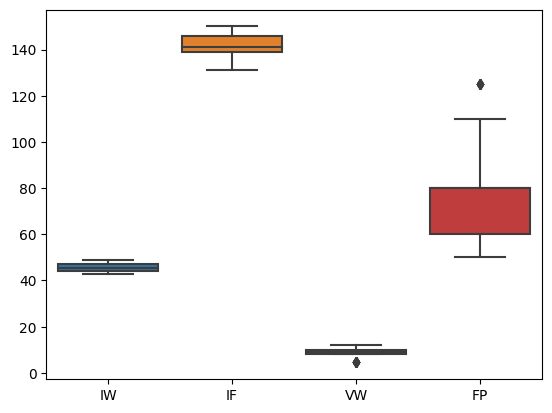

In [14]:
sns.boxplot(X)

**Так как значения переменных `FP` имеют явные выбросы, предлагается заменить их медианой**

In [15]:
median_fp = X["FP"].median()
std_fp = X["FP"].std()

X.loc[X["FP"] > median_fp + 2 * std_fp, "FP"] = median_fp

<Axes: >

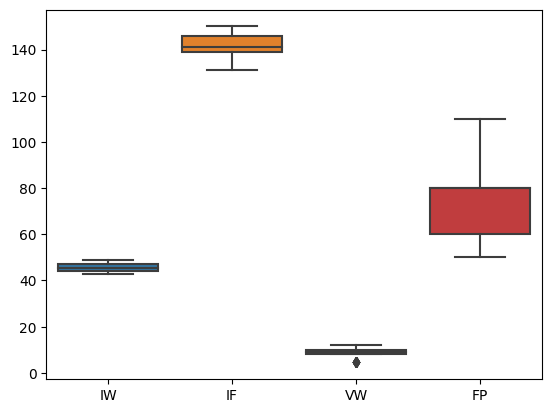

In [16]:
sns.boxplot(X)

**Разбиваем данные на обучающую и тестовую выборки**

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    train_size=0.8, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle=True)

**Так как значения переменных имеют достаточно большой диапазон значений в дальнейшем целесообразна их нормализация и стандартизация**

In [18]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### **Работа с моделями**
ntBoслучайного леса (а
   model рессия с использованием нейронных сетей:
   ```python
   from sklearn.neural_network import MLPRegressor
   
   # Создание модели с использованием многослойного персептрона (нейронной сети)
   model = MLPRegressor()
   ```
   
Это только небольшой список доступных моделей для задач регрессии в `scikit-learn`. Каждая из этих моделей имеет ряд параметров, которые можно настроить для получения наилучших результатов на конкретном наборе данных.

#### Линейная регрессия: `LinearRegression`

In [19]:
from sklearn.linear_model import LinearRegression

# Создание модели
model_lr = LinearRegression()

# Обучение модели
model_lr.fit(X_train, Y_train)

# Оценка модели
mean_absolute_error(Y_test, model_lr.predict(X_test), multioutput='raw_values')

array([0.15838774, 0.07065272])

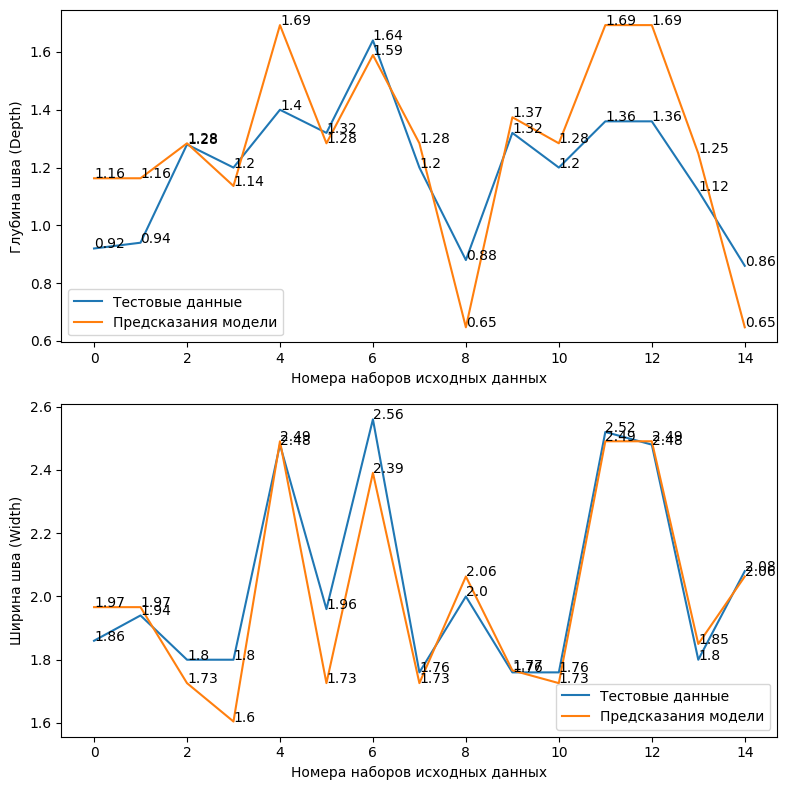

Cредняя абсолютная ошибка при предсказании глубины шва (Depth):	~ 15.8 %
Cредняя абсолютная ошибка при предсказании ширины шва (Width):	~ 7.1 %


In [20]:
show_model_quality_visualization(model_lr, X_test, Y_test)

**Сохранение модели**

In [21]:
y_pred = model_lr.predict(X_test)

In [22]:
y_pred

array([[1.16300745, 1.96622168],
       [1.16300745, 1.96622168],
       [1.28399132, 1.7259862 ],
       [1.13629691, 1.6046404 ],
       [1.69300869, 2.49058777],
       [1.28399132, 1.7259862 ],
       [1.58947526, 2.39079153],
       [1.28399132, 1.7259862 ],
       [0.64725452, 2.06320395],
       [1.37419292, 1.76627022],
       [1.28399132, 1.7259862 ],
       [1.69300869, 2.49058777],
       [1.69300869, 2.49058777],
       [1.24888083, 1.84986619],
       [0.64725452, 2.06320395]])

In [23]:
import pickle

In [24]:
pickle.dump(model_lr, open('lr_model.pkl', 'wb'))

In [25]:
model_load = pickle.load(open('lr_model.pkl', 'rb'))

In [26]:
X_test

array([[0.75      , 0.2       , 0.73333333, 1.        ],
       [0.75      , 0.2       , 0.73333333, 1.        ],
       [0.        , 1.        , 0.6       , 0.        ],
       [0.75      , 0.66666667, 1.        , 0.4       ],
       [0.75      , 0.53333333, 0.        , 0.4       ],
       [0.        , 1.        , 0.6       , 0.        ],
       [0.25      , 0.6       , 0.        , 0.4       ],
       [0.        , 1.        , 0.6       , 0.        ],
       [1.        , 0.        , 0.73333333, 0.4       ],
       [0.25      , 1.        , 0.6       , 0.        ],
       [0.        , 1.        , 0.6       , 0.        ],
       [0.75      , 0.53333333, 0.        , 0.4       ],
       [0.75      , 0.53333333, 0.        , 0.4       ],
       [0.75      , 0.6       , 0.73333333, 0.4       ],
       [1.        , 0.        , 0.73333333, 0.4       ]])

In [27]:
model_load.predict(X_test)

array([[1.16300745, 1.96622168],
       [1.16300745, 1.96622168],
       [1.28399132, 1.7259862 ],
       [1.13629691, 1.6046404 ],
       [1.69300869, 2.49058777],
       [1.28399132, 1.7259862 ],
       [1.58947526, 2.39079153],
       [1.28399132, 1.7259862 ],
       [0.64725452, 2.06320395],
       [1.37419292, 1.76627022],
       [1.28399132, 1.7259862 ],
       [1.69300869, 2.49058777],
       [1.69300869, 2.49058777],
       [1.24888083, 1.84986619],
       [0.64725452, 2.06320395]])

#### Регрессия с использованием k-ближайших соседей: `KNeighborsRegressor`

In [28]:
from sklearn.neighbors import KNeighborsRegressor

# Создание модели с использованием 3-х ближайших соседей
model_kn = KNeighborsRegressor(n_neighbors=3)

# Обучение модели
model_kn.fit(X_train, Y_train)

# Оценка модели
mean_absolute_error(Y_test, model_kn.predict(X_test), multioutput='raw_values')

array([0.11866667, 0.06911111])

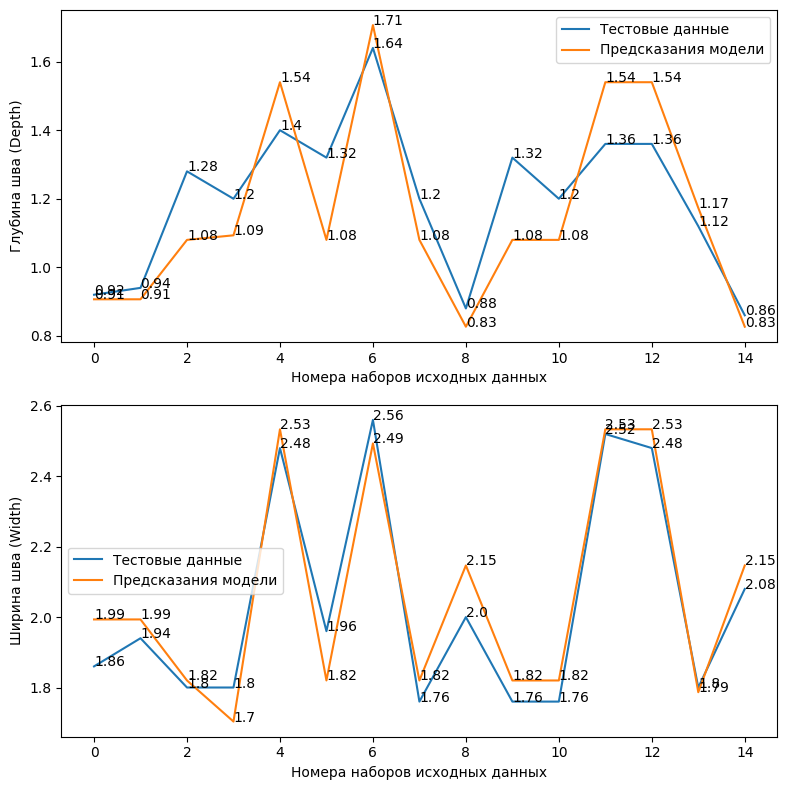

Cредняя абсолютная ошибка при предсказании глубины шва (Depth):	~ 11.9 %
Cредняя абсолютная ошибка при предсказании ширины шва (Width):	~ 6.9 %


In [29]:
show_model_quality_visualization(model_kn, X_test, Y_test)

#### Регрессия с использованием деревьев решений: `DecisionTreeRegressor`

In [30]:
from sklearn.tree import DecisionTreeRegressor
   
# Создание модели с использованием дерева решений
model_dtr = DecisionTreeRegressor()

# Обучение модели
model_dtr.fit(X_train, Y_train)

# Оценка модели
mean_absolute_error(Y_test, model_dtr.predict(X_test), multioutput='raw_values')

array([0.15377778, 0.05433333])

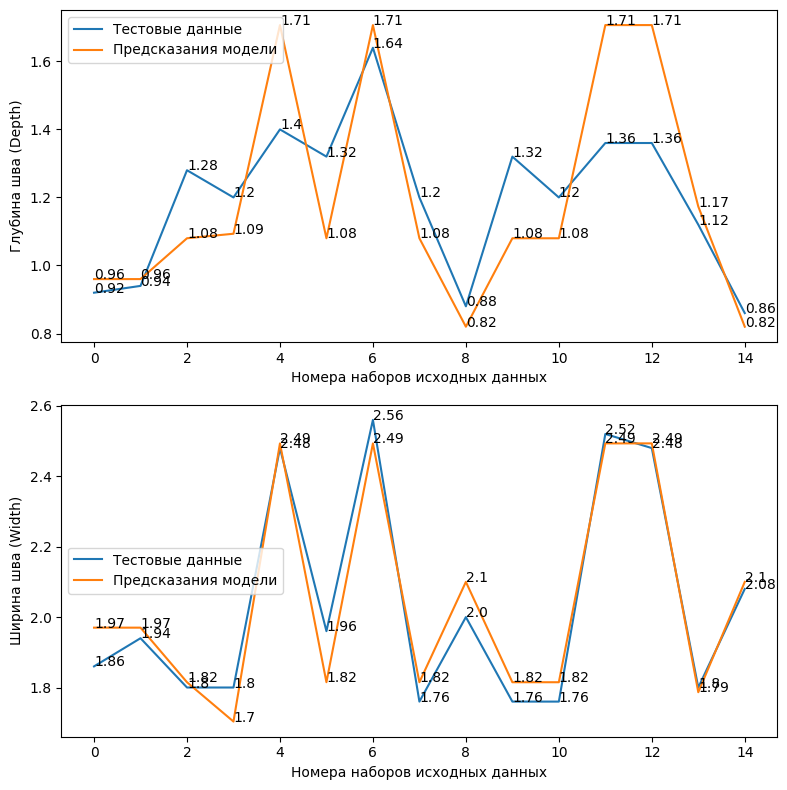

Cредняя абсолютная ошибка при предсказании глубины шва (Depth):	~ 15.4 %
Cредняя абсолютная ошибка при предсказании ширины шва (Width):	~ 5.4 %


In [31]:
show_model_quality_visualization(model_dtr, X_test, Y_test)

#### Регрессия с использованием случайного леса: `RandomForestRegressor`

In [32]:
from sklearn.ensemble import RandomForestRegressor
   
# Создание модели с использованием случайного леса
model_rfr = RandomForestRegressor(n_estimators=5000)

# Обучение модели
model_rfr.fit(X_train, Y_train)

# Оценка модели
mean_absolute_error(Y_test, model_rfr.predict(X_test), multioutput='raw_values')

array([0.1287013 , 0.06295373])

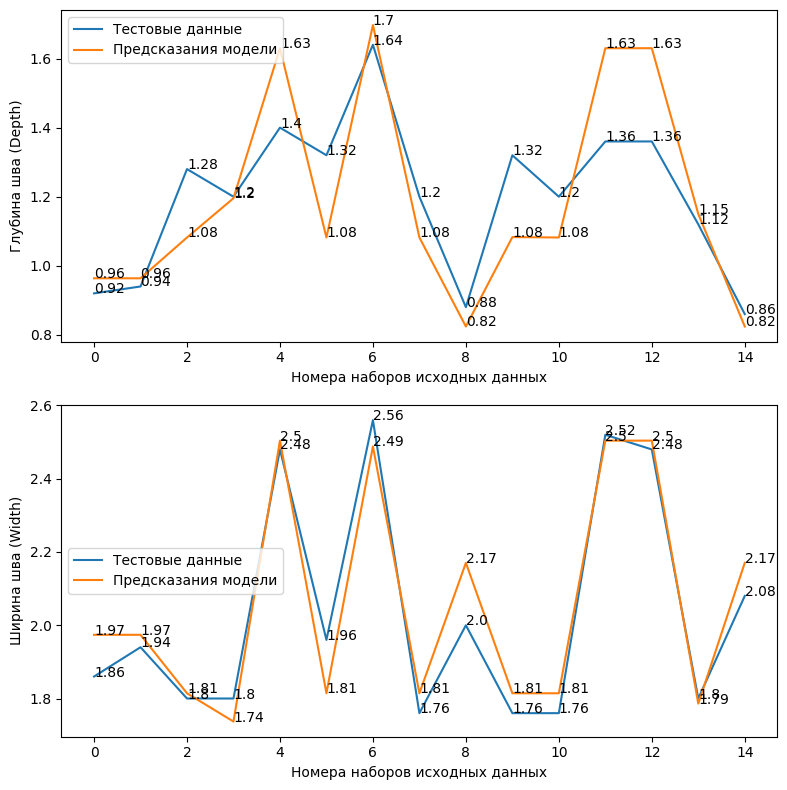

Cредняя абсолютная ошибка при предсказании глубины шва (Depth):	~ 12.9 %
Cредняя абсолютная ошибка при предсказании ширины шва (Width):	~ 6.3 %


In [33]:
show_model_quality_visualization(model_rfr, X_test, Y_test)

#### MultiOutputRegressor

In [34]:
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

base_model = SVR()
model_mor = MultiOutputRegressor(base_model)

# Обучение модели
model_mor.fit(X_train, Y_train)

# Оценка модели
mean_absolute_error(Y_test, model_mor.predict(X_test), multioutput='raw_values')

array([0.07632022, 0.08709597])

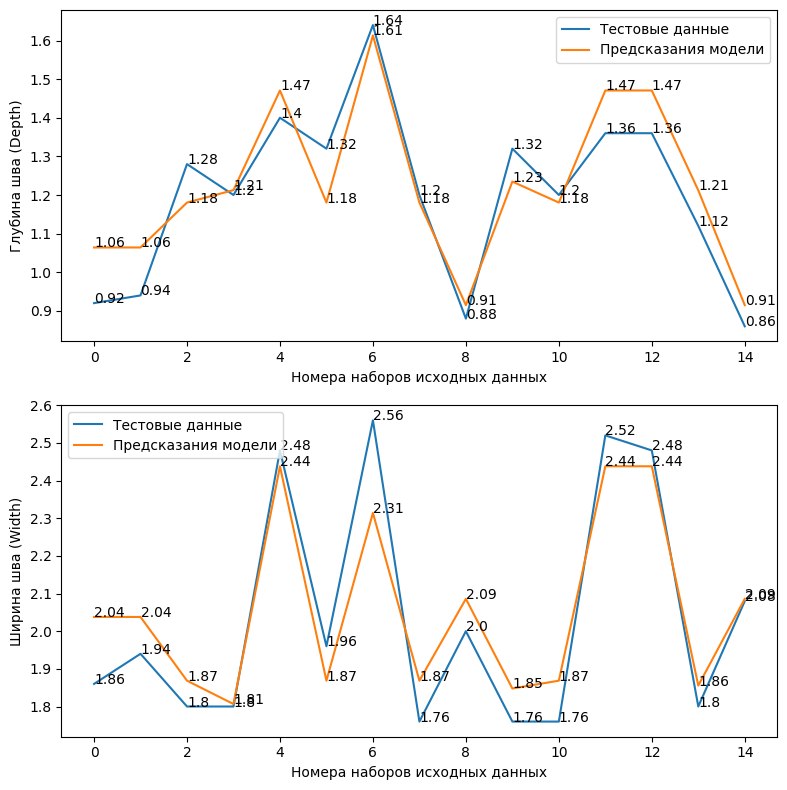

Cредняя абсолютная ошибка при предсказании глубины шва (Depth):	~ 7.6 %
Cредняя абсолютная ошибка при предсказании ширины шва (Width):	~ 8.7 %


In [35]:
show_model_quality_visualization(model_mor, X_test, Y_test)

**Сохранение модели**

In [36]:
y_pred = model_lr.predict(X_test)
y_pred

array([[1.16300745, 1.96622168],
       [1.16300745, 1.96622168],
       [1.28399132, 1.7259862 ],
       [1.13629691, 1.6046404 ],
       [1.69300869, 2.49058777],
       [1.28399132, 1.7259862 ],
       [1.58947526, 2.39079153],
       [1.28399132, 1.7259862 ],
       [0.64725452, 2.06320395],
       [1.37419292, 1.76627022],
       [1.28399132, 1.7259862 ],
       [1.69300869, 2.49058777],
       [1.69300869, 2.49058777],
       [1.24888083, 1.84986619],
       [0.64725452, 2.06320395]])

In [37]:
import pickle

In [38]:
pickle.dump(model_mor, open('mor_model.pkl', 'wb'))

In [39]:
model_load = pickle.load(open('mor_model.pkl', 'rb'))

In [40]:
X_test

array([[0.75      , 0.2       , 0.73333333, 1.        ],
       [0.75      , 0.2       , 0.73333333, 1.        ],
       [0.        , 1.        , 0.6       , 0.        ],
       [0.75      , 0.66666667, 1.        , 0.4       ],
       [0.75      , 0.53333333, 0.        , 0.4       ],
       [0.        , 1.        , 0.6       , 0.        ],
       [0.25      , 0.6       , 0.        , 0.4       ],
       [0.        , 1.        , 0.6       , 0.        ],
       [1.        , 0.        , 0.73333333, 0.4       ],
       [0.25      , 1.        , 0.6       , 0.        ],
       [0.        , 1.        , 0.6       , 0.        ],
       [0.75      , 0.53333333, 0.        , 0.4       ],
       [0.75      , 0.53333333, 0.        , 0.4       ],
       [0.75      , 0.6       , 0.73333333, 0.4       ],
       [1.        , 0.        , 0.73333333, 0.4       ]])

In [41]:
model_load.predict(X_test)

array([[1.06415722, 2.03776013],
       [1.06415722, 2.03776013],
       [1.18043191, 1.86856045],
       [1.21263243, 1.80655537],
       [1.47060698, 2.43797217],
       [1.18043191, 1.86856045],
       [1.61315347, 2.31402193],
       [1.18043191, 1.86856045],
       [0.91479285, 2.08589589],
       [1.2347299 , 1.84782297],
       [1.18043191, 1.86856045],
       [1.47060698, 2.43797217],
       [1.47060698, 2.43797217],
       [1.21206079, 1.85556668],
       [0.91479285, 2.08589589]])

#### CCA

In [42]:
from sklearn.datasets import make_regression
from sklearn.cross_decomposition import CCA

model_cca = CCA()

# Обучение модели
model_cca.fit(X_train, Y_train)

# Оценка модели
mean_absolute_error(Y_test, model_cca.predict(X_test), multioutput='raw_values')

array([0.12081965, 0.07389231])

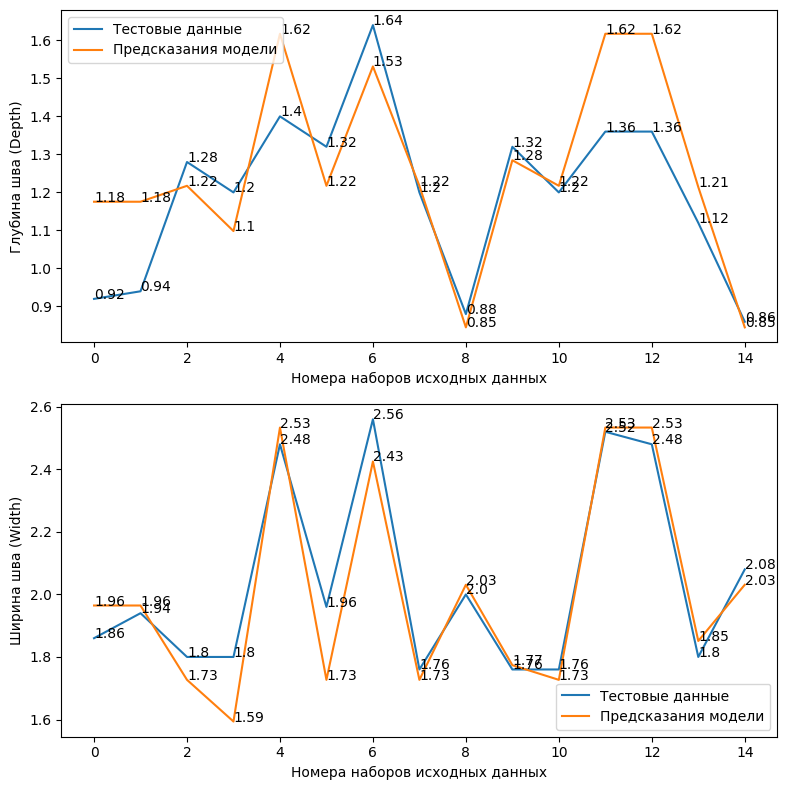

Cредняя абсолютная ошибка при предсказании глубины шва (Depth):	~ 12.1 %
Cредняя абсолютная ошибка при предсказании ширины шва (Width):	~ 7.4 %


In [43]:
show_model_quality_visualization(model_cca, X_test, Y_test)

#### Использования ансамбля градиентного бустинга: `XGBoost`

In [44]:
import xgboost as xgb

# Создание экземпляра модели градиентного бустинга
model_xgb = xgb.XGBRegressor()

# Обучение модели на тренировочных данных
model_xgb.fit(X_train, Y_train)

# Оценка модели
mean_absolute_error(Y_test, model_xgb.predict(X_test), multioutput='raw_values')

array([0.13184975, 0.06272448])

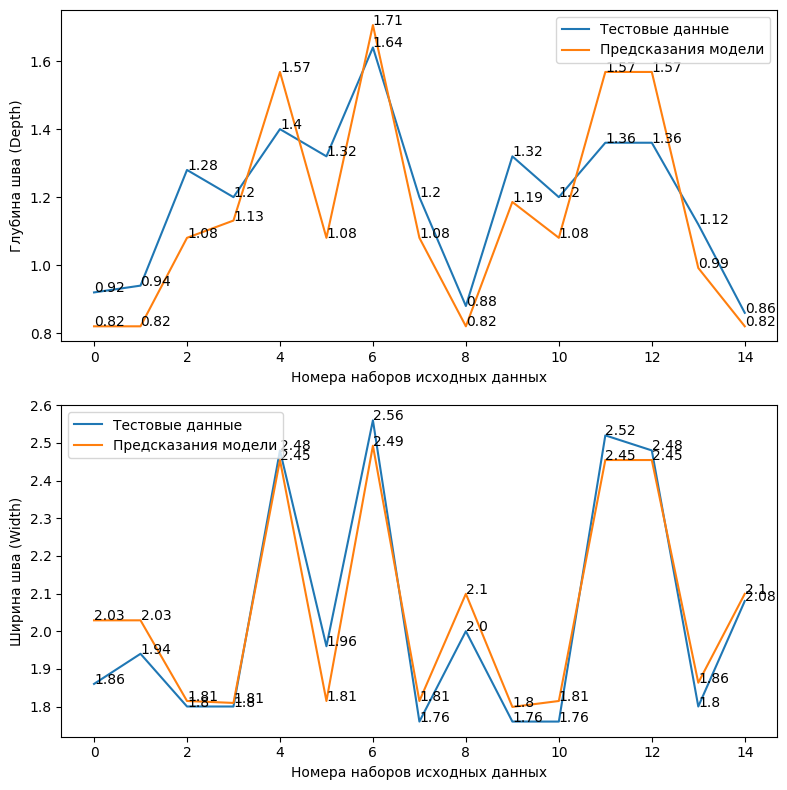

Cредняя абсолютная ошибка при предсказании глубины шва (Depth):	~ 13.2 %
Cредняя абсолютная ошибка при предсказании ширины шва (Width):	~ 6.3 %


In [45]:
show_model_quality_visualization(model_xgb, X_test, Y_test)

Наилучший результат при котором средняя абсолютная ошибка глубины шва (Depth) = 9.5 % и ширины шва (Width) = 8.6 % показала модель с использованием `LinearRegression`.

**На этой модель предлагается отсановиться**